In [1]:
import numpy as np
import struct

In [2]:
file_path = "./storage/txrx_file.dat"
sample_size = 8
with open(file_path, 'rb') as f:
    # Read the binary data
    binary_data = f.read()

num_samples = len(binary_data) // sample_size
samples = []
for i in range(num_samples):
    # Extract real and imaginary parts from the binary data
    real_part, imag_part = struct.unpack('ff', binary_data[i * sample_size: (i + 1) * sample_size])
    # Create a complex number and append it to the list of samples
    samples.append(complex(real_part, imag_part))

samples = np.array(samples)
samples.shape

(3160,)

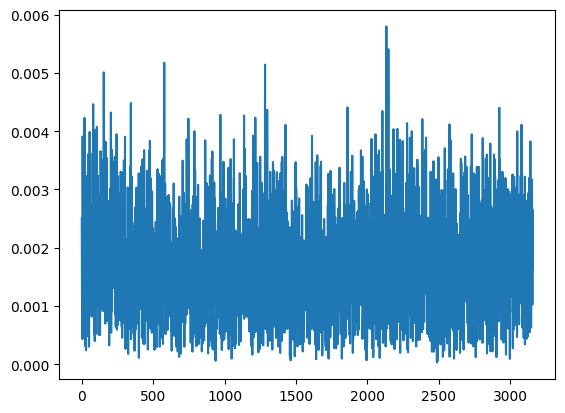

In [3]:
from matplotlib import pyplot as plt
plt.plot(np.abs(samples))

In [4]:
N = 79
M = 41
R = 1
U = 1
zfc_seq = np.array([np.exp(-1j * np.pi * M * n * (n + 1) / N) for n in range(N)])
zfc_seq_upsamp = np.zeros((N*U), dtype=complex)
for i in range(N):
    zfc_seq_upsamp[i*U] = zfc_seq[i]

# zfc_seq_rep = np.tile(zfc_seq, R)
print(zfc_seq_upsamp.shape)
# plt.plot(np.abs(zfc_seq_upsamp))

(79,)


0.19999999999999998


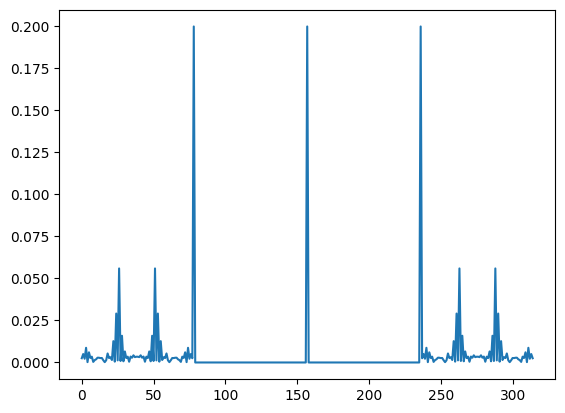

In [13]:
corr_zfc = np.correlate(np.tile(0.2 * zfc_seq, 3), zfc_seq, mode='full') / N
plt.plot(np.abs(corr_zfc))
print(np.max(np.abs(corr_zfc)))

973342


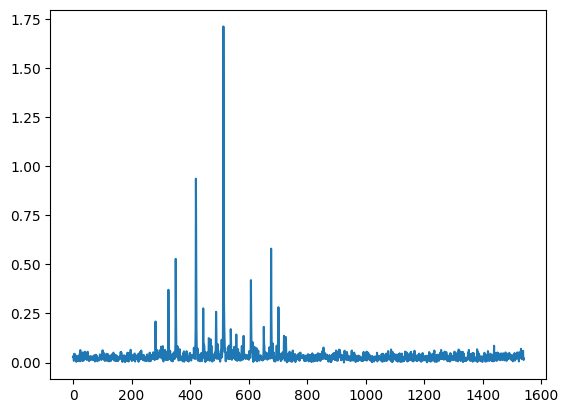

In [22]:
plot_data = np.abs(corr_zfc)
pmax = np.argmax(plot_data).item()
print(pmax)

plt.plot(plot_data[pmax - 2 * N * U : pmax + 4 * N * U])

# print(np.diff(np.argwhere(plot_data > 60.0).squeeze()))
# print(plot_data[np.argwhere(plot_data > 60.0).squeeze()])


0.031927373661379974
0.004675075713641289
0.00213184144996236


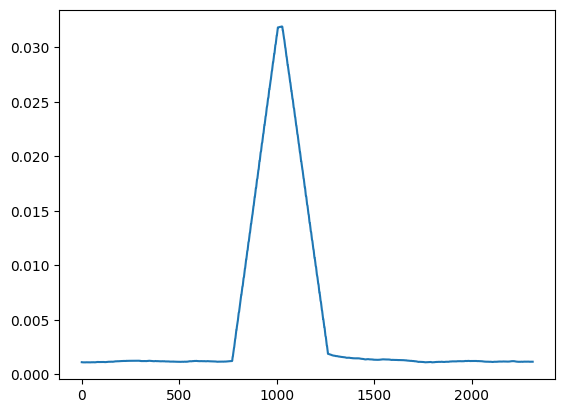

In [13]:
# floating window - to find the threshold
window_len = N
relevant_signal = np.abs(samples[pmax-5*N : pmax + 5*N])
ma_signal = np.zeros((relevant_signal.size - N + 1), dtype=float)
for i in range(ma_signal.size):
    for j in range(N):
        ma_signal[i] += relevant_signal[i + j]
    ma_signal[i] /= N
plt.plot(ma_signal)
print(np.max(ma_signal))
pp = np.argmax(ma_signal).squeeze()
print(np.mean(ma_signal))
print(np.mean(np.delete(ma_signal, np.arange(pp - N//2 - 1, pp + N//2 + 1))))
# plt.yscale("log")